# Instead of test the algorithms and affinity on the whole dataset, this notebook test data from each trial, which is what we need in implementation.

# With anchor object

# SSP encoding. 

Encode the data set as bolt_ssp^c1 * nut_ssp^c2 * table_ssp^c3* jig_ssp^c4 * X_sp^x * Y_sp^y * Z_sp^z

<IPython.core.display.Javascript object>


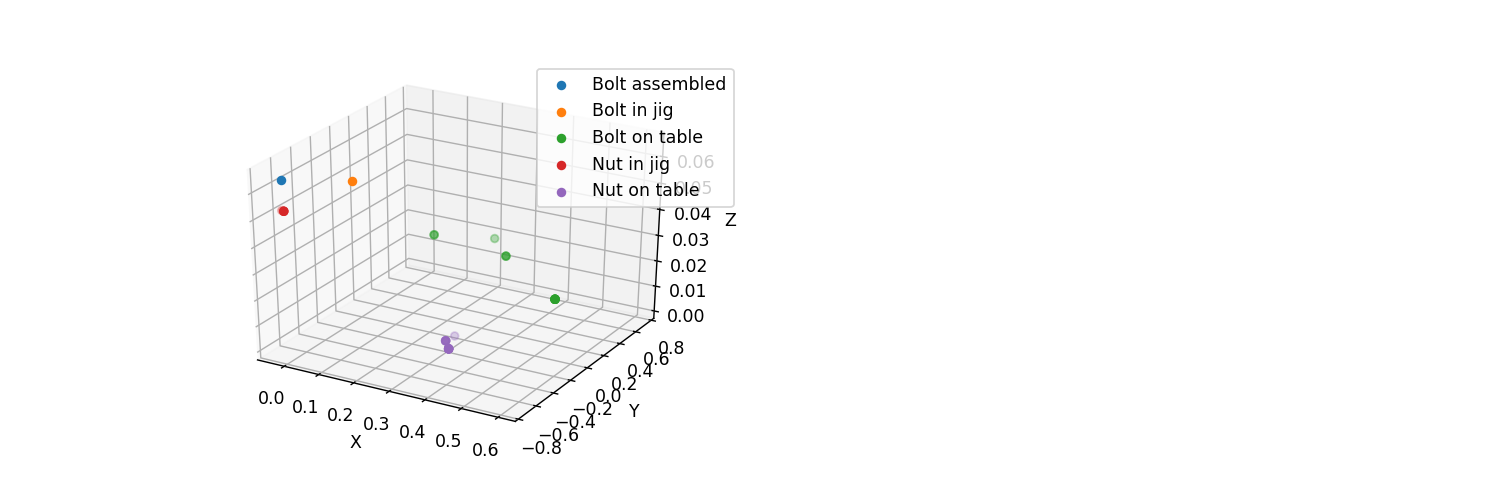

In [1]:
import numpy as np
%matplotlib notebook
import sys
sys.path.append('..')

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from utils.data import fetch_data, fetch_data_with_label, fetch_data_with_label_per_step, generate_data, label_to_int, divide_data
from utils.plotting import plot
from utils.clustering import agglomerative, kmeans, gaussian_mixture, Clustering
from sklearn.metrics import adjusted_rand_score
import itertools


logfile_path = ['../data/raw/1599166289/data.pickle', '../data/raw/1599153598/data.pickle', '../data/raw/test/data.pickle']

#coordinates and object kind for nut and bolt
data_concat, label = fetch_data_with_label_per_step(logfile_path)

ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))


coord = selected_data[:,0:3]
obj_kind = selected_data[:, 3]

fig = plt.figure(1, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord, selected_label)


In [2]:
def balance_data(data, labels):
    count = []
    for label in set(labels):
        count.append((labels == label).sum())
    max_count = max(count)
    for label in set(labels):
        n_data = (labels == label).sum()
        if n_data < max_count:
            ind = np.where(labels == label)[0]
            selected_data = data[ind, :]
            average = np.average(selected_data, axis = 0)
            n_needed = max_count - n_data
            data_needed = np.tile(average, (n_needed, 1))
            label_needed = np.tile(label, n_needed)
            data = np.concatenate((data, data_needed), axis = 0)
            labels = np.concatenate((labels, label_needed))
    return data, labels


from utils.encoding import power, make_good_unitary, encode_point, encode_dataset
import nengo.spa as spa

def encode_property(data, sps): # encode as power instead of multiplication
    '''
    data: an n by m array. n is the number of data points, m is the number of possible choices of the property being encoded.
          (ex. when encoding object kind, the possible choices of object kind are 'bolt' and 'nut').
    sps: A list of size m. Each entry is the semantic pointer for each of the possible choices.
    '''
    n = data.shape[0]
    dim = len(sps[0].v)
    result = []
    for i in range(n):
        temp = 1
        for j, sp in enumerate(sps):
            temp *= power(sp, data[i,j])
        result.append(temp)
            
    return np.array(result)

def encode_dataset(data, x_axis_sp, y_axis_sp, z_axis_sp, encoded_kind_sp, encoded_anchor_sp):
    
    n = data.shape[0]
    dim = len(x_axis_sp.v)
    result = np.zeros((n, dim))
    for i in range(n):
        x = data[i][0].item()
        y = data[i][2].item()
        z = data[i][1].item()
        point_encoded = encode_point(x, y, z, x_axis_sp, y_axis_sp, z_axis_sp)
        result[i, :] = (point_encoded * encoded_kind_sp[i] * encoded_anchor_sp[i]).v
    return result
        
dim = 256
x_axis_sp = make_good_unitary(dim)
y_axis_sp = make_good_unitary(dim)
z_axis_sp = make_good_unitary(dim)

bolt_sp = make_good_unitary(dim)
nut_sp = make_good_unitary(dim)

table_sp = make_good_unitary(dim)
jig_sp = make_good_unitary(dim)

# Agglomerative with Euclidean and number of clusters. Object kind, anchor object are used as a soft constrain.

<IPython.core.display.Javascript object>


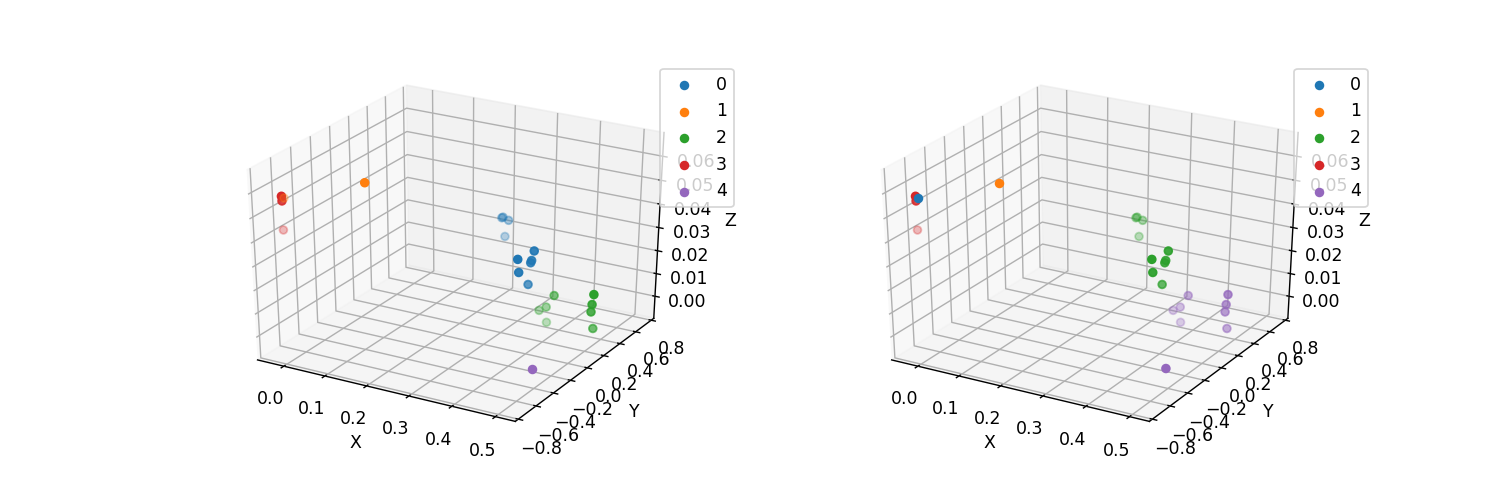

The accuracy for nut and bolt is 0.7434801402430239


In [3]:
u_coord = 0  # The average shift between the approximated coordinates and ground truth
sigma_coord = 0.006
u_kind = 0.1
sigma_kind = 0.05
u_anchor = 0.1
sigma_anchor = 0.05

ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
selected_label_int = label_to_int(selected_label_balanced)
# selected_label_int = label_to_int(selected_label)

coord = selected_data_balanced[:,0:3]
obj_kind = selected_data_balanced[:, 3]

# coord = selected_data[:,0:3]
# obj_kind = selected_data[:, 3]

noise = np.random.normal(u_coord, sigma_coord, coord.shape)
coord_noisy = coord + noise

ind_nut = np.where(obj_kind == 0)[0]
ind_bolt = np.where(obj_kind == 1)[0]

n_data = coord.shape[0]
one_hot_kind = np.zeros((n_data,2))
one_hot_kind[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
kind_noisy = abs(one_hot_kind - np.column_stack((noise_kind, noise_kind)))

ind_table = np.concatenate((np.where(selected_label_balanced == 'Nut on table')[0], np.where(selected_label_balanced == 'Bolt on table')[0]))
# ind_table = np.concatenate((np.where(selected_label == 'Nut on table')[0], np.where(selected_label == 'Bolt on table')[0]))
ind_jig = np.delete(np.arange(n_data), ind_table)
one_hot_anchor = np.zeros((n_data,2))
one_hot_anchor[ind_table,0] = 1
one_hot_anchor[ind_jig,1] = 1
noise_anchor = np.random.normal(u_anchor, sigma_anchor, obj_kind.size)
anchor_noisy = abs(one_hot_anchor - np.column_stack((noise_anchor, noise_anchor)))

encoded_kind = encode_property(kind_noisy, [nut_sp, bolt_sp])
encoded_anchor = encode_property(anchor_noisy, [table_sp, jig_sp])
data_encoded = encode_dataset(coord_noisy, x_axis_sp, y_axis_sp, z_axis_sp, encoded_kind, encoded_anchor)

estimated_label_concat = agglomerative(data_encoded, 'euclidean', thres = None, n_clusters = 5)
n_original = selected_data.shape[0]

fig = plt.figure(3, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_noisy[:n_original,:], estimated_label_concat[:n_original])
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(ax, coord_noisy[:n_original,:], selected_label_int[:n_original])
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat, selected_label_int)}')

In [4]:
n_test = 100
accuracy = 0
for i in range(n_test):
    ind = np.random.choice(len(data_concat))
    selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
    selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
    selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
    selected_label_int = label_to_int(selected_label_balanced)
    # selected_label_int = label_to_int(selected_label)

    coord = selected_data_balanced[:,0:3]
    obj_kind = selected_data_balanced[:, 3]

    # coord = selected_data[:,0:3]
    # obj_kind = selected_data[:, 3]

    noise = np.random.normal(u_coord, sigma_coord, coord.shape)
    coord_noisy = coord + noise

    ind_nut = np.where(obj_kind == 0)[0]
    ind_bolt = np.where(obj_kind == 1)[0]

    n_data = coord.shape[0]
    one_hot_kind = np.zeros((n_data,2))
    one_hot_kind[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
    noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
    kind_noisy = abs(one_hot_kind - np.column_stack((noise_kind, noise_kind)))

    ind_table = np.concatenate((np.where(selected_label_balanced == 'Nut on table')[0], np.where(selected_label_balanced == 'Bolt on table')[0]))
    # ind_table = np.concatenate((np.where(selected_label == 'Nut on table')[0], np.where(selected_label == 'Bolt on table')[0]))
    ind_jig = np.delete(np.arange(n_data), ind_table)
    one_hot_anchor = np.zeros((n_data,2))
    one_hot_anchor[ind_table,0] = 1
    one_hot_anchor[ind_jig,1] = 1
    noise_anchor = np.random.normal(u_anchor, sigma_anchor, obj_kind.size)
    anchor_noisy = abs(one_hot_anchor - np.column_stack((noise_anchor, noise_anchor)))

    encoded_kind = encode_property(kind_noisy, [nut_sp, bolt_sp])
    encoded_anchor = encode_property(anchor_noisy, [table_sp, jig_sp])
    data_encoded = encode_dataset(coord_noisy, x_axis_sp, y_axis_sp, z_axis_sp, encoded_kind, encoded_anchor)

    estimated_label_concat = agglomerative(data_encoded, 'euclidean', thres = None, n_clusters = 5)
    n_original = selected_data.shape[0]

    accuracy += adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])
    
print(accuracy / n_test)

0.8280035331350739


# Agglomerative with Cosine and number of clusters. Object kind, anchor object are used as a soft constrain.

<IPython.core.display.Javascript object>


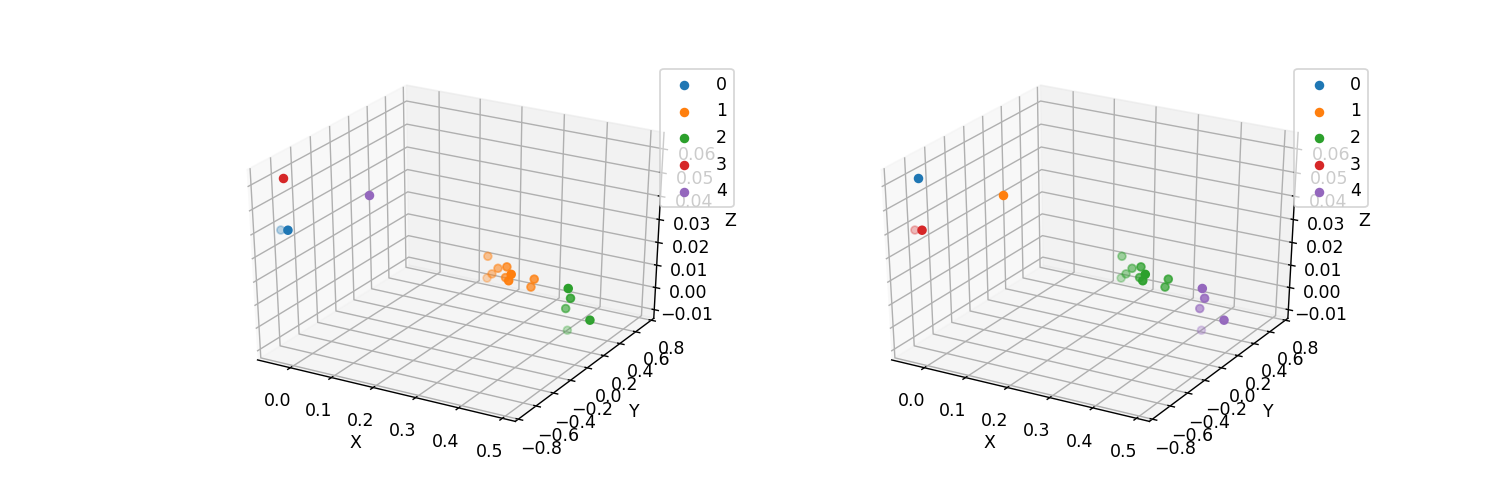

The accuracy for nut and bolt is 1.0


In [5]:
u_coord = 0  # The average shift between the approximated coordinates and ground truth
sigma_coord = 0.006
u_kind = 0.1
sigma_kind = 0.05
u_anchor = 0.1
sigma_anchor = 0.05

ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
selected_label_int = label_to_int(selected_label_balanced)
# selected_label_int = label_to_int(selected_label)

coord = selected_data_balanced[:,0:3]
obj_kind = selected_data_balanced[:, 3]

# coord = selected_data[:,0:3]
# obj_kind = selected_data[:, 3]

noise = np.random.normal(u_coord, sigma_coord, coord.shape)
coord_noisy = coord + noise

ind_nut = np.where(obj_kind == 0)[0]
ind_bolt = np.where(obj_kind == 1)[0]

n_data = coord.shape[0]
one_hot_kind = np.zeros((n_data,2))
one_hot_kind[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
kind_noisy = abs(one_hot_kind - np.column_stack((noise_kind, noise_kind)))

ind_table = np.concatenate((np.where(selected_label_balanced == 'Nut on table')[0], np.where(selected_label_balanced == 'Bolt on table')[0]))
# ind_table = np.concatenate((np.where(selected_label == 'Nut on table')[0], np.where(selected_label == 'Bolt on table')[0]))
ind_jig = np.delete(np.arange(n_data), ind_table)
one_hot_anchor = np.zeros((n_data,2))
one_hot_anchor[ind_table,0] = 1
one_hot_anchor[ind_jig,1] = 1
noise_anchor = np.random.normal(u_anchor, sigma_anchor, obj_kind.size)
anchor_noisy = abs(one_hot_anchor - np.column_stack((noise_anchor, noise_anchor)))

encoded_kind = encode_property(kind_noisy, [nut_sp, bolt_sp])
encoded_anchor = encode_property(anchor_noisy, [table_sp, jig_sp])
data_encoded = encode_dataset(coord_noisy, x_axis_sp, y_axis_sp, z_axis_sp, encoded_kind, encoded_anchor)

estimated_label_concat = agglomerative(data_encoded, 'cosine', thres = None, n_clusters = 5)
n_original = selected_data.shape[0]

fig = plt.figure(4, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_noisy[:n_original,:], estimated_label_concat[:n_original])
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(ax, coord_noisy[:n_original,:], selected_label_int[:n_original])
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat, selected_label_int)}')

In [6]:
n_test = 100
accuracy = 0
for i in range(n_test):
    ind = np.random.choice(len(data_concat))
    selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
    selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
    selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
    selected_label_int = label_to_int(selected_label_balanced)
    # selected_label_int = label_to_int(selected_label)

    coord = selected_data_balanced[:,0:3]
    obj_kind = selected_data_balanced[:, 3]

    # coord = selected_data[:,0:3]
    # obj_kind = selected_data[:, 3]

    noise = np.random.normal(u_coord, sigma_coord, coord.shape)
    coord_noisy = coord + noise

    ind_nut = np.where(obj_kind == 0)[0]
    ind_bolt = np.where(obj_kind == 1)[0]

    n_data = coord.shape[0]
    one_hot_kind = np.zeros((n_data,2))
    one_hot_kind[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
    noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
    kind_noisy = abs(one_hot_kind - np.column_stack((noise_kind, noise_kind)))

    ind_table = np.concatenate((np.where(selected_label_balanced == 'Nut on table')[0], np.where(selected_label_balanced == 'Bolt on table')[0]))
    # ind_table = np.concatenate((np.where(selected_label == 'Nut on table')[0], np.where(selected_label == 'Bolt on table')[0]))
    ind_jig = np.delete(np.arange(n_data), ind_table)
    one_hot_anchor = np.zeros((n_data,2))
    one_hot_anchor[ind_table,0] = 1
    one_hot_anchor[ind_jig,1] = 1
    noise_anchor = np.random.normal(u_anchor, sigma_anchor, obj_kind.size)
    anchor_noisy = abs(one_hot_anchor - np.column_stack((noise_anchor, noise_anchor)))

    encoded_kind = encode_property(kind_noisy, [nut_sp, bolt_sp])
    encoded_anchor = encode_property(anchor_noisy, [table_sp, jig_sp])
    data_encoded = encode_dataset(coord_noisy, x_axis_sp, y_axis_sp, z_axis_sp, encoded_kind, encoded_anchor)

    estimated_label_concat = agglomerative(data_encoded, 'cosine', thres = None, n_clusters = 5)
    n_original = selected_data.shape[0]

    accuracy += adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])
    
print(accuracy / n_test)

0.8386409127301638


# Kmeans with Euclidean and number of clusters. 

<IPython.core.display.Javascript object>


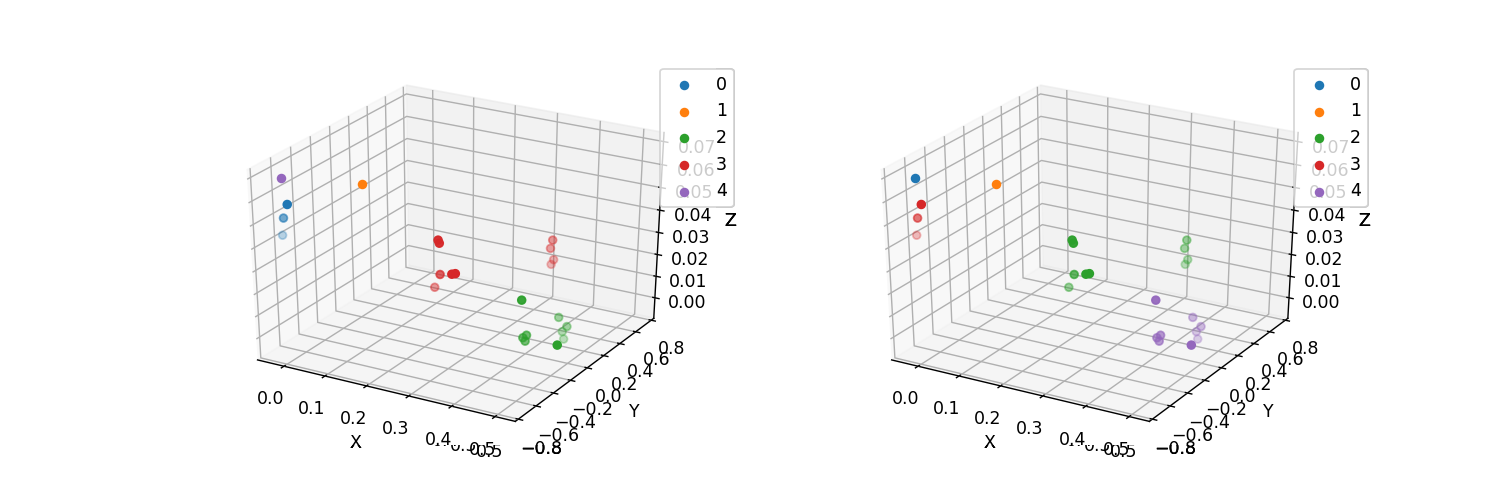

The accuracy for nut and bolt is 0.6970275429506408


In [7]:
u_coord = 0  # The average shift between the approximated coordinates and ground truth
sigma_coord = 0.006
u_kind = 0.1
sigma_kind = 0.05
u_anchor = 0.1
sigma_anchor = 0.05

ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
selected_label_int = label_to_int(selected_label_balanced)
# selected_label_int = label_to_int(selected_label)

coord = selected_data_balanced[:,0:3]
obj_kind = selected_data_balanced[:, 3]

# coord = selected_data[:,0:3]
# obj_kind = selected_data[:, 3]

noise = np.random.normal(u_coord, sigma_coord, coord.shape)
coord_noisy = coord + noise

ind_nut = np.where(obj_kind == 0)[0]
ind_bolt = np.where(obj_kind == 1)[0]

n_data = coord.shape[0]
one_hot_kind = np.zeros((n_data,2))
one_hot_kind[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
kind_noisy = abs(one_hot_kind - np.column_stack((noise_kind, noise_kind)))

ind_table = np.concatenate((np.where(selected_label_balanced == 'Nut on table')[0], np.where(selected_label_balanced == 'Bolt on table')[0]))
# ind_table = np.concatenate((np.where(selected_label == 'Nut on table')[0], np.where(selected_label == 'Bolt on table')[0]))
ind_jig = np.delete(np.arange(n_data), ind_table)
one_hot_anchor = np.zeros((n_data,2))
one_hot_anchor[ind_table,0] = 1
one_hot_anchor[ind_jig,1] = 1
noise_anchor = np.random.normal(u_anchor, sigma_anchor, obj_kind.size)
anchor_noisy = abs(one_hot_anchor - np.column_stack((noise_anchor, noise_anchor)))

encoded_kind = encode_property(kind_noisy, [nut_sp, bolt_sp])
encoded_anchor = encode_property(anchor_noisy, [table_sp, jig_sp])
data_encoded = encode_dataset(coord_noisy, x_axis_sp, y_axis_sp, z_axis_sp, encoded_kind, encoded_anchor)

estimated_label_concat, centers = kmeans(data_encoded, n_clusters = 5 , affinity = 'euclidean')
n_original = selected_data.shape[0]

fig = plt.figure(5, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_noisy[:n_original,:], estimated_label_concat[:n_original])
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(ax, coord_noisy[:n_original,:], selected_label_int[:n_original])
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat, selected_label_int)}')

In [8]:
n_test = 100
accuracy = 0
for i in range(n_test):
    ind = np.random.choice(len(data_concat))
    selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
    selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
    selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
    selected_label_int = label_to_int(selected_label_balanced)
    # selected_label_int = label_to_int(selected_label)

    coord = selected_data_balanced[:,0:3]
    obj_kind = selected_data_balanced[:, 3]

    # coord = selected_data[:,0:3]
    # obj_kind = selected_data[:, 3]

    noise = np.random.normal(u_coord, sigma_coord, coord.shape)
    coord_noisy = coord + noise

    ind_nut = np.where(obj_kind == 0)[0]
    ind_bolt = np.where(obj_kind == 1)[0]

    n_data = coord.shape[0]
    one_hot_kind = np.zeros((n_data,2))
    one_hot_kind[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
    noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
    kind_noisy = abs(one_hot_kind - np.column_stack((noise_kind, noise_kind)))

    ind_table = np.concatenate((np.where(selected_label_balanced == 'Nut on table')[0], np.where(selected_label_balanced == 'Bolt on table')[0]))
    # ind_table = np.concatenate((np.where(selected_label == 'Nut on table')[0], np.where(selected_label == 'Bolt on table')[0]))
    ind_jig = np.delete(np.arange(n_data), ind_table)
    one_hot_anchor = np.zeros((n_data,2))
    one_hot_anchor[ind_table,0] = 1
    one_hot_anchor[ind_jig,1] = 1
    noise_anchor = np.random.normal(u_anchor, sigma_anchor, obj_kind.size)
    anchor_noisy = abs(one_hot_anchor - np.column_stack((noise_anchor, noise_anchor)))

    encoded_kind = encode_property(kind_noisy, [nut_sp, bolt_sp])
    encoded_anchor = encode_property(anchor_noisy, [table_sp, jig_sp])
    data_encoded = encode_dataset(coord_noisy, x_axis_sp, y_axis_sp, z_axis_sp, encoded_kind, encoded_anchor)

    estimated_label_concat, centers = kmeans(data_encoded, n_clusters = 5 , affinity = 'euclidean')
    n_original = selected_data.shape[0]

    accuracy += adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])
    
print(accuracy / n_test)

0.9243845579556053


# Kmeans with Cosine and number of clusters. 

In [9]:
u_coord = 0  # The average shift between the approximated coordinates and ground truth
sigma_coord = 0.006
u_kind = 0.1
sigma_kind = 0.05
u_anchor = 0.1
sigma_anchor = 0.05

ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
selected_label_int = label_to_int(selected_label_balanced)
# selected_label_int = label_to_int(selected_label)

coord = selected_data_balanced[:,0:3]
obj_kind = selected_data_balanced[:, 3]

# coord = selected_data[:,0:3]
# obj_kind = selected_data[:, 3]

noise = np.random.normal(u_coord, sigma_coord, coord.shape)
coord_noisy = coord + noise

ind_nut = np.where(obj_kind == 0)[0]
ind_bolt = np.where(obj_kind == 1)[0]

n_data = coord.shape[0]
one_hot_kind = np.zeros((n_data,2))
one_hot_kind[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
kind_noisy = abs(one_hot_kind - np.column_stack((noise_kind, noise_kind)))

ind_table = np.concatenate((np.where(selected_label_balanced == 'Nut on table')[0], np.where(selected_label_balanced == 'Bolt on table')[0]))
# ind_table = np.concatenate((np.where(selected_label == 'Nut on table')[0], np.where(selected_label == 'Bolt on table')[0]))
ind_jig = np.delete(np.arange(n_data), ind_table)
one_hot_anchor = np.zeros((n_data,2))
one_hot_anchor[ind_table,0] = 1
one_hot_anchor[ind_jig,1] = 1
noise_anchor = np.random.normal(u_anchor, sigma_anchor, obj_kind.size)
anchor_noisy = abs(one_hot_anchor - np.column_stack((noise_anchor, noise_anchor)))

encoded_kind = encode_property(kind_noisy, [nut_sp, bolt_sp])
encoded_anchor = encode_property(anchor_noisy, [table_sp, jig_sp])
data_encoded = encode_dataset(coord_noisy, x_axis_sp, y_axis_sp, z_axis_sp, encoded_kind, encoded_anchor)

estimated_label_concat, centers = kmeans(data_encoded, n_clusters = 5 , affinity = 'cosine')
n_original = selected_data.shape[0]

fig = plt.figure(5, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_noisy[:n_original,:], estimated_label_concat[:n_original])
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(ax, coord_noisy[:n_original,:], selected_label_int[:n_original])
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat, selected_label_int)}')

The accuracy for nut and bolt is 1.0


In [10]:
n_test = 100
accuracy = 0
for i in range(n_test):
    ind = np.random.choice(len(data_concat))
    selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
    selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
    selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
    selected_label_int = label_to_int(selected_label_balanced)
    # selected_label_int = label_to_int(selected_label)

    coord = selected_data_balanced[:,0:3]
    obj_kind = selected_data_balanced[:, 3]

    # coord = selected_data[:,0:3]
    # obj_kind = selected_data[:, 3]

    noise = np.random.normal(u_coord, sigma_coord, coord.shape)
    coord_noisy = coord + noise

    ind_nut = np.where(obj_kind == 0)[0]
    ind_bolt = np.where(obj_kind == 1)[0]

    n_data = coord.shape[0]
    one_hot_kind = np.zeros((n_data,2))
    one_hot_kind[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
    noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
    kind_noisy = abs(one_hot_kind - np.column_stack((noise_kind, noise_kind)))

    ind_table = np.concatenate((np.where(selected_label_balanced == 'Nut on table')[0], np.where(selected_label_balanced == 'Bolt on table')[0]))
    # ind_table = np.concatenate((np.where(selected_label == 'Nut on table')[0], np.where(selected_label == 'Bolt on table')[0]))
    ind_jig = np.delete(np.arange(n_data), ind_table)
    one_hot_anchor = np.zeros((n_data,2))
    one_hot_anchor[ind_table,0] = 1
    one_hot_anchor[ind_jig,1] = 1
    noise_anchor = np.random.normal(u_anchor, sigma_anchor, obj_kind.size)
    anchor_noisy = abs(one_hot_anchor - np.column_stack((noise_anchor, noise_anchor)))

    encoded_kind = encode_property(kind_noisy, [nut_sp, bolt_sp])
    encoded_anchor = encode_property(anchor_noisy, [table_sp, jig_sp])
    data_encoded = encode_dataset(coord_noisy, x_axis_sp, y_axis_sp, z_axis_sp, encoded_kind, encoded_anchor)

    estimated_label_concat, centers = kmeans(data_encoded, n_clusters = 5 , affinity = 'cosine')
    n_original = selected_data.shape[0]

    accuracy += adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])
    
print(accuracy / n_test)

0.8568634302067251


# Gaussian mixture model

In [11]:
u_coord = 0  # The average shift between the approximated coordinates and ground truth
sigma_coord = 0.006
u_kind = 0.1
sigma_kind = 0.05
u_anchor = 0.1
sigma_anchor = 0.05

ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
selected_label_int = label_to_int(selected_label_balanced)
# selected_label_int = label_to_int(selected_label)

coord = selected_data_balanced[:,0:3]
obj_kind = selected_data_balanced[:, 3]

# coord = selected_data[:,0:3]
# obj_kind = selected_data[:, 3]

noise = np.random.normal(u_coord, sigma_coord, coord.shape)
coord_noisy = coord + noise

ind_nut = np.where(obj_kind == 0)[0]
ind_bolt = np.where(obj_kind == 1)[0]

n_data = coord.shape[0]
one_hot_kind = np.zeros((n_data,2))
one_hot_kind[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
kind_noisy = abs(one_hot_kind - np.column_stack((noise_kind, noise_kind)))

ind_table = np.concatenate((np.where(selected_label_balanced == 'Nut on table')[0], np.where(selected_label_balanced == 'Bolt on table')[0]))
# ind_table = np.concatenate((np.where(selected_label == 'Nut on table')[0], np.where(selected_label == 'Bolt on table')[0]))
ind_jig = np.delete(np.arange(n_data), ind_table)
one_hot_anchor = np.zeros((n_data,2))
one_hot_anchor[ind_table,0] = 1
one_hot_anchor[ind_jig,1] = 1
noise_anchor = np.random.normal(u_anchor, sigma_anchor, obj_kind.size)
anchor_noisy = abs(one_hot_anchor - np.column_stack((noise_anchor, noise_anchor)))

encoded_kind = encode_property(kind_noisy, [nut_sp, bolt_sp])
encoded_anchor = encode_property(anchor_noisy, [table_sp, jig_sp])
data_encoded = encode_dataset(coord_noisy, x_axis_sp, y_axis_sp, z_axis_sp, encoded_kind, encoded_anchor)

estimated_label_concat , centers= gaussian_mixture(data_encoded, n_clusters = 5)
n_original = selected_data.shape[0]

fig = plt.figure(5, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_noisy[:n_original,:], estimated_label_concat[:n_original])
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(ax, coord_noisy[:n_original,:], selected_label_int[:n_original])
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat, selected_label_int)}')

The accuracy for nut and bolt is 1.0


In [12]:
n_test = 100
accuracy = 0
for i in range(n_test):
    ind = np.random.choice(len(data_concat))
    selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
    selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
    selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
    selected_label_int = label_to_int(selected_label_balanced)
    # selected_label_int = label_to_int(selected_label)

    coord = selected_data_balanced[:,0:3]
    obj_kind = selected_data_balanced[:, 3]

    # coord = selected_data[:,0:3]
    # obj_kind = selected_data[:, 3]

    noise = np.random.normal(u_coord, sigma_coord, coord.shape)
    coord_noisy = coord + noise

    ind_nut = np.where(obj_kind == 0)[0]
    ind_bolt = np.where(obj_kind == 1)[0]

    n_data = coord.shape[0]
    one_hot_kind = np.zeros((n_data,2))
    one_hot_kind[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
    noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
    kind_noisy = abs(one_hot_kind - np.column_stack((noise_kind, noise_kind)))

    ind_table = np.concatenate((np.where(selected_label_balanced == 'Nut on table')[0], np.where(selected_label_balanced == 'Bolt on table')[0]))
    # ind_table = np.concatenate((np.where(selected_label == 'Nut on table')[0], np.where(selected_label == 'Bolt on table')[0]))
    ind_jig = np.delete(np.arange(n_data), ind_table)
    one_hot_anchor = np.zeros((n_data,2))
    one_hot_anchor[ind_table,0] = 1
    one_hot_anchor[ind_jig,1] = 1
    noise_anchor = np.random.normal(u_anchor, sigma_anchor, obj_kind.size)
    anchor_noisy = abs(one_hot_anchor - np.column_stack((noise_anchor, noise_anchor)))

    encoded_kind = encode_property(kind_noisy, [nut_sp, bolt_sp])
    encoded_anchor = encode_property(anchor_noisy, [table_sp, jig_sp])
    data_encoded = encode_dataset(coord_noisy, x_axis_sp, y_axis_sp, z_axis_sp, encoded_kind, encoded_anchor)

    eestimated_label_concat , centers= gaussian_mixture(data_encoded, n_clusters = 5)
    n_original = selected_data.shape[0]

    accuracy += adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])
    
print(accuracy / n_test)

0.8891717500435661
